## DQN

In [3]:
"""
经验回放池
"""
import collections
import random
class ReplayBuffer():
    def __init__(self,maxlen):
        self.buffer=collections.deque(maxlen=maxlen)
    def add(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))
    def sample(self,batch_size):
        data=random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done=zip(*data)
        return np.array(state),action,reward,np.array(next_state),done
    def size(self):
        return len(self.buffer)
        

In [4]:
"""Qnet"""
from torch import nn,optim
import torch
class Qnet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim))
    def forward(self,x):
        return self.fc2(self.fc1(x))


In [5]:
import torch.nn.functional as F
class DQN():
    def __init__(self,state_dim,hidden_dim,action_dim,lr,gamma,eps,target_update,device):
        self.action_dim=action_dim
        self.q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.target_q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=optim.Adam(self.q_net.parameters(),lr=lr)
        self.gamma=gamma
        self.eps=eps
        self.target_update=target_update
        self.count=0
        self.device=device
        #print(state_dim)
    def take_action(self,state):
        if(np.random.random()<self.eps):
            action=np.random.randint(self.action_dim)
        else:
            #print(state)
            state=torch.tensor(np.array([state]),dtype=torch.float).to(device)
            #print(state.shape)
            action=self.q_net(state).argmax().item()
        return action
    def update(self,trans_dict):
        states=torch.tensor(trans_dict['states'],dtype=torch.float).to(self.device)
        actions=torch.tensor(trans_dict['actions']).view(-1,1).to(self.device)
        rewards=torch.tensor(trans_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        new_states=torch.tensor(trans_dict['new_states'],dtype=torch.float).to(self.device)
        dones=torch.tensor(trans_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)
        
        q_values=self.q_net(states).gather(1,actions)
        max_next_q_values=self.target_q_net(new_states).max(1)[0].view(-1,1)
        q_targets=rewards+self.gamma*max_next_q_values*(1-dones)
        dqn_loss=torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        if self.count%self.target_update==0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict()
            )
        self.count+=1

In [6]:
import numpy as np
import gym
lr=2e-3
epochs=500
eps=0.01
gamma=0.98
hidden_dim=128
target_update=10
buffer_size=10000
minimal_size=500
batch_size=64
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
env_name='CartPole-v1'
env=gym.make(env_name)
random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer=ReplayBuffer(buffer_size)
state_dim=env.observation_space.shape[0]
action_dim=env.action_space.n
agent=DQN(state_dim,hidden_dim,action_dim,lr,gamma,eps,target_update,device)
device


device(type='cuda', index=0)

In [10]:
from tqdm import tqdm
return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state,_=env.reset(seed=0)
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,_,done,_=env.step(action)
                replay_buffer.add(state,action,r,new_state,done)
                new_action=agent.take_action(new_state)
                rewards+=r
                state=new_state
                action=new_action
                if replay_buffer.size()>minimal_size:
                    b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                    tran_dict={
                        'states':b_s,
                        'actions':b_a,
                        'new_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d,
                    }
                    agent.update(tran_dict)
                
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)


iter 9: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it, epoch=500, return=176.300]


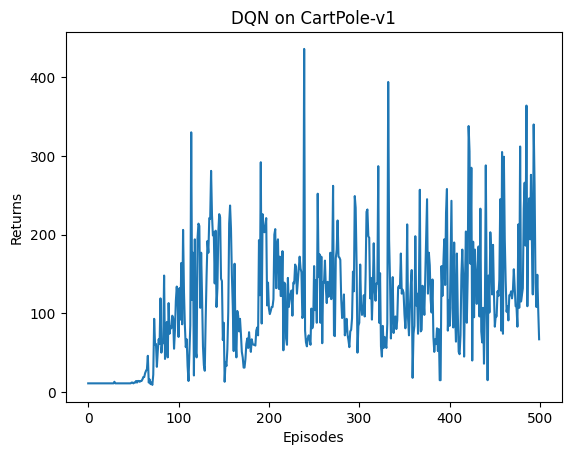

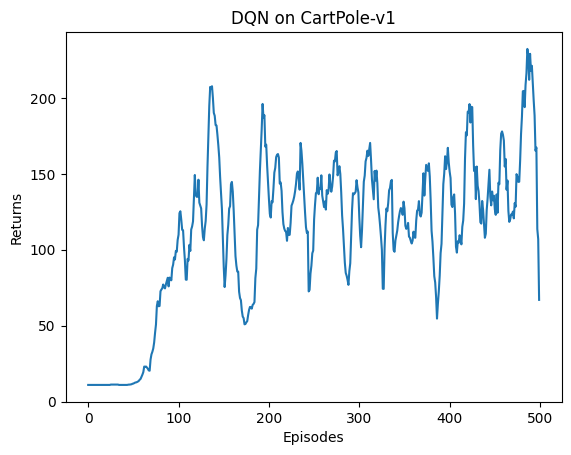

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(return_list)),return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

new_list=moving_average(return_list,9)
plt.plot(range(len(new_list)),new_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [46]:
env.step(action)

/opt/conda/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([ 0.1506175,  1.7413381, -0.2803097, -2.9581785], dtype=float32),
 0.0,
 True,
 False,
 {})

## Double-DQN
### 缓解DQN对Q过高估计问题

In [62]:
import torch.nn.functional as F
class double_DQN():
    def __init__(self,state_dim,hidden_dim,action_dim,lr,gamma,eps,target_update,device,DQN_type):
        self.action_dim=action_dim
        self.q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.target_q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=optim.Adam(self.q_net.parameters(),lr=lr)
        self.gamma=gamma
        self.eps=eps
        self.target_update=target_update
        self.count=0
        self.device=device
        self.DQN_type=DQN_type
        #print(state_dim)
    def max_q_value(self,state):
        state=torch.tensor(np.array([state]),dtype=torch.float).to(device)
        return self.q_net(state).max().item()
    def take_action(self,state):
        if(np.random.random()<self.eps):
            action=np.random.randint(self.action_dim)
        else:
            #print(state)
            state=torch.tensor(np.array([state]),dtype=torch.float).to(device)
            #print(state.shape)
            action=self.q_net(state).argmax().item()
        return action
    def update(self,trans_dict):
        states=torch.tensor(trans_dict['states'],dtype=torch.float).to(self.device)
        actions=torch.tensor(trans_dict['actions']).view(-1,1).to(self.device)
        rewards=torch.tensor(trans_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        new_states=torch.tensor(trans_dict['next_states'],dtype=torch.float).to(self.device)
        dones=torch.tensor(trans_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)
        
        q_values=self.q_net(states).gather(1,actions)
        if self.DQN_type=='double':
            max_next_q_a=self.q_net(new_states).max(1)[1].view(-1,1)
            max_next_q_values=self.target_q_net(new_states).gather(1,max_next_q_a)
        else :
            max_next_q_values=self.target_q_net(new_states).max(1)[0].view(-1,1)
        q_targets=rewards+self.gamma*max_next_q_values*(1-dones)
        dqn_loss=torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        
        if self.count%self.target_update==0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict()
            )
        self.count+=1

In [7]:
import numpy as np
import gym
lr=1e-2
epochs=200
eps=0.01
gamma=0.98
hidden_dim=128
target_update=50
buffer_size=5000
minimal_size=1000
batch_size=64
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
env_name='Pendulum-v1'
env=gym.make(env_name)
random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer=ReplayBuffer(buffer_size)
state_dim=env.observation_space.shape[0]
action_dim = 11 #将连续动作转成11个离散动作

def dis_to_con(dis_action,env,action_dim):#离散动作转回连续
    action_lower=env.action_space.low[0]
    action_upper=env.action_space.high[0]
    return action_lower+dis_action*(
        (action_upper-action_lower)/action_dim
    )
agent=DQN(state_dim,hidden_dim,action_dim,lr,gamma,eps,target_update,device)
device


device(type='cuda', index=0)

In [8]:
from tqdm import tqdm

def train(agent,env,epochs,replay_buffer,minimal_size,batch_size):
    return_list=[]
    max_q_value_list=[]
    max_q_value=0
    for i in range(10):
        with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
            for epoch in range(epochs//10):
                rewards=0
                state,_=env.reset(seed=0)
                action=agent.take_action(state)
                done=False
                while not done:
                    max_q_value=agent.max_q_value(state)*0.005+0.995*max_q_value
                    max_q_value_list.append(max_q_value)
                    action_con=dis_to_con(action,env,agent.action_dim)
                    new_state,r,done1,done,_=env.step([action_con])
                    replay_buffer.add(state,action,r,new_state,done)
                    new_action=agent.take_action(new_state)
                    rewards+=r
                    state=new_state
                    action=new_action
                    if replay_buffer.size()>minimal_size:
                        b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                        tran_dict={
                            'states':b_s,
                            'actions':b_a,
                            'next_states':b_ns,
                            'rewards':b_r,
                            'dones':b_d,
                        }
                        agent.update(tran_dict)

                return_list.append(rewards)
                if (epoch+1) %10==0:
                    pbar.set_postfix({
                        'epoch':'%d'%(epochs//10*i+epoch+1),
                        'return':'%.3f'%np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list,max_q_value_list



iter 9: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s, epoch=200, return=-138.561]


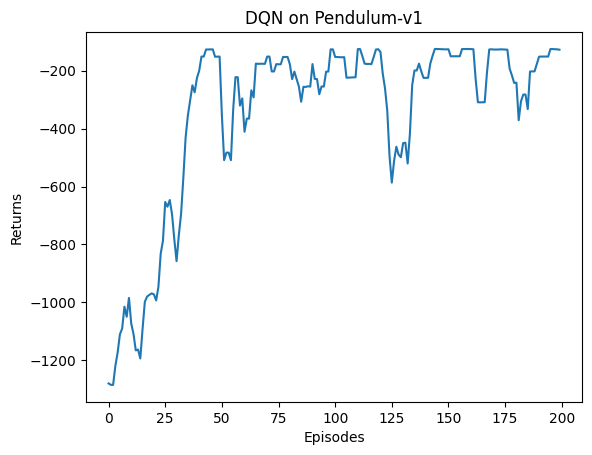

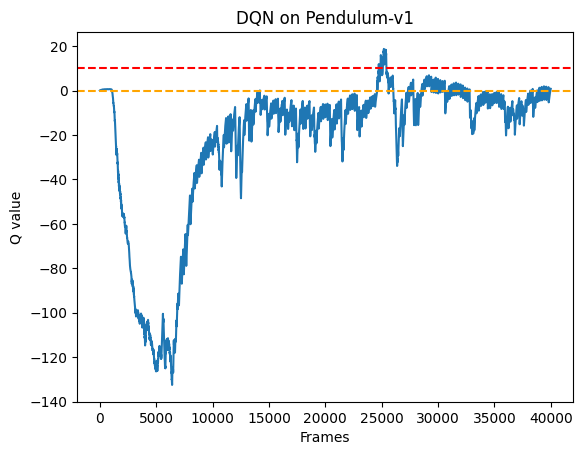

In [65]:
## double_DQN结果
replay_buffer =ReplayBuffer(buffer_size)
agent =double_DQN(state_dim, hidden_dim, action_dim, lr, gamma, eps,
            target_update, device,'double')
return_list, max_q_value_list = train(agent, env, epochs,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return =moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

iter 9: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s, epoch=200, return=-152.669]


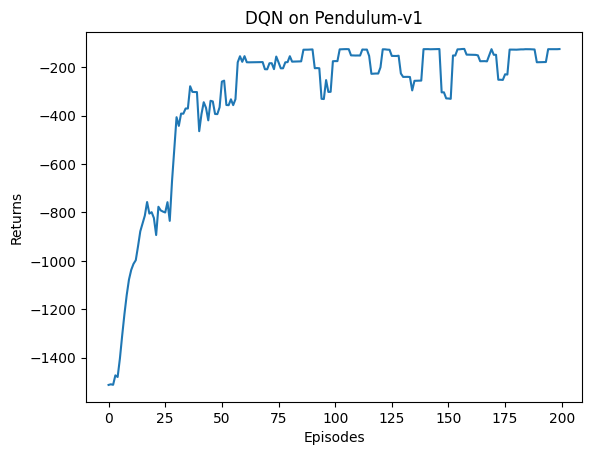

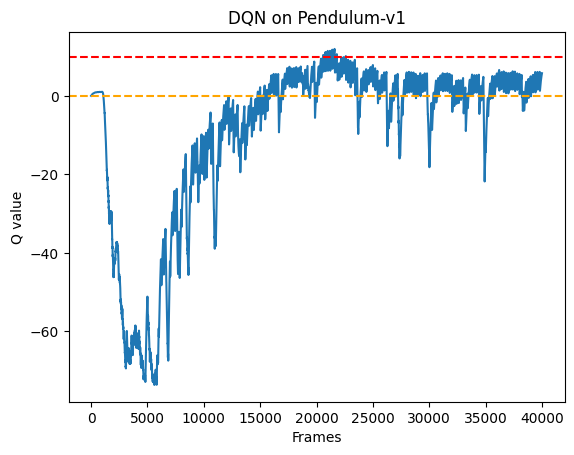

In [66]:
## DQN结果
replay_buffer =ReplayBuffer(buffer_size)
agent =double_DQN(state_dim, hidden_dim, action_dim, lr, gamma, eps,
            target_update, device,'')
return_list, max_q_value_list = train(agent, env, epochs,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return =moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [31]:
action_con=dis_to_con(6,env,agent.action_dim)
env.step([action_con])

(array([-0.6347586, -0.7727105, -2.705564 ], dtype=float32),
 -4.946719722483681,
 False,
 False,
 {})

## Dueling DQN

In [9]:
class VAnet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fcA=nn.Sequential(nn.Linear(hidden_dim,action_dim))
        self.fcV=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        x=self.fc1(x)
        A=self.fcA(x)
        V=self.fcV(x)
        Q=V+A-A.mean(1).view(-1,1)
        return Q

In [31]:
class Dueling_DQN():
    def __init__(self,state_dim,hidden_dim,action_dim,lr,
                 gamma,eps,target_update,device,dqn_type='DuelingDQN'
                ):
        self.action_dim=action_dim
        self.gamma=gamma
        self.eps=eps
        self.target_update=target_update
        self.device=device
        self.dqn_type=dqn_type
        
        if dqn_type=='DuelingDQN':
            self.q_net=VAnet(state_dim,hidden_dim,action_dim).to(device)
            self.target_q_net=VAnet(state_dim,hidden_dim,action_dim).to(device)
        else:
            self.q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
            self.target_q_net=Qnet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=optim.Adam(self.q_net.parameters(),lr=lr)
        self.count=0
    def take_action(self,state):
        if np.random.random()<self.eps:
            action=np.random.randint(self.action_dim)
        else:
            state=torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action=self.q_net(state).max(1)[1].item()
        return action
    
    def max_q_value(self,state):
        state=torch.FloatTensor(state).unsqueeze(0).to(self.device)
        return self.q_net(state).max(1)[0].item()
    
    def update(self,trans_dict):
        states=torch.tensor(trans_dict['states'],dtype=torch.float).to(self.device)
        actions=torch.tensor(trans_dict['actions']).view(-1,1).to(self.device)
        rewards=torch.tensor(trans_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        new_states=torch.tensor(trans_dict['next_states'],dtype=torch.float).to(self.device)
        dones=torch.tensor(trans_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)
        
        q_values=self.q_net(states).gather(1,actions)
        if self.dqn_type=='DuelingDQN':
            max_next_q_values=self.target_q_net(new_states).max(1)[0].view(-1,1)
        else:
            max_next_q_action=self.q_net(new_states).max(1)[1].view(-1,1)
            max_next_q_values=self.target_q_net(new_states).gather(1,max_next_q_action)
        q_targets=rewards+self.gamma*max_next_q_values*(1-dones)
        dqn_loss=torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        
        if (self.count)%self.target_update==0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict()
            )
        self.count+=1
    
    

In [32]:


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = Dueling_DQN(state_dim, hidden_dim, action_dim, lr, gamma, eps,
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train(agent, env,epochs,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

iter 9: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s, epoch=200, return=-150.846]


NameError: name 'rl_utils' is not defined

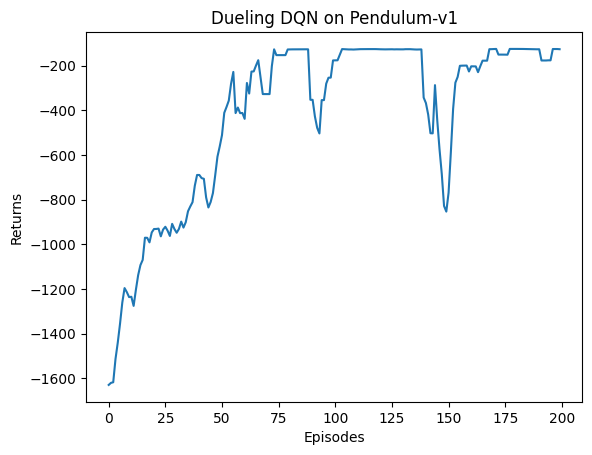

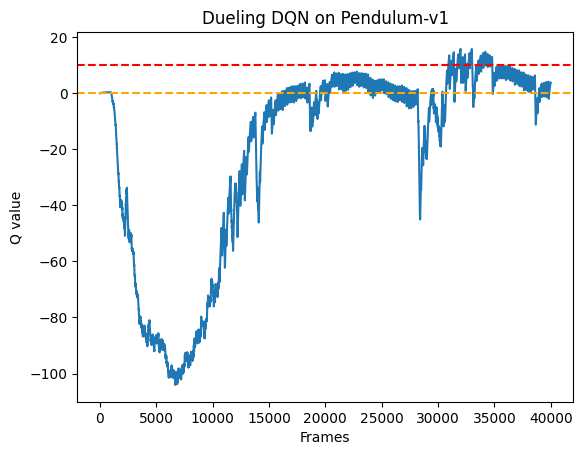

In [35]:
import matplotlib.pyplot as plt
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()